# Time Series Evaluation

This notebook demonstrates the usage of different ramsey models on time series data from [The M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128).

First the necessary libraries are imported and 64bit support for JAX library is enabled.

In [1]:

import jax
import haiku as hk
import numpy as np
from jax import numpy as jnp, random
import matplotlib.pyplot as plt
from ramsey.data import m4_datasets, load_m4_dataset, get_m4_time_series

%matplotlib inline
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)

Next helper functions for loading the dataset are defined.

In [2]:
def load_data(key, ds_name : str, n_series : int = 1, n_observations : int = None):
    
  series_prefix = m4_datasets[ds_name]['series_prefix']

  train, test = load_m4_dataset(ds_name)

  idxs = random.choice(
    key, jnp.arange(start=0, stop=len(train)), shape=(n_series,), replace=False
  )

  series_names = [(series_prefix + str(idx)) for idx in idxs]

  if n_observations == None:
      n_observations = m4_datasets[ds_name]['n_observations']

  n_forecasts = m4_datasets[ds_name]['n_forecasts']

  x_train_arr = np.zeros((len(idxs), n_observations))
  y_train_arr = np.zeros((len(idxs), n_observations))
  x_test_arr = np.zeros((len(idxs), n_forecasts))
  y_test_arr = np.zeros((len(idxs), n_forecasts))


  for idx, series_name in enumerate(series_names):

      x_train, y_train, x_test, y_test = get_m4_time_series(series_name, train, test)

      x_train = x_train[-n_observations:,:]
      y_train = y_train[-n_observations:,:]

      x_test = x_test[-n_forecasts:,:]
      y_test = y_test[-n_forecasts:,:]

      x_train_norm = x_train - jnp.min(x_train)
      y_train_norm = (y_train - jnp.mean(y_train)) / jnp.std(y_train)
      
      x_test_norm = x_test - jnp.min(x_train)
      y_test_norm = (y_test - jnp.mean(y_train)) / jnp.std(y_train)
      
      x_train_arr[idx, np.newaxis] = x_train_norm.T
      y_train_arr[idx,np.newaxis] = y_train_norm.T

      x_test_arr[idx,np.newaxis] = x_test_norm.T
      y_test_arr[idx,np.newaxis] = y_test_norm.T


  return jnp.array(x_train_arr), jnp.array(y_train_arr), jnp.array(x_test_arr), jnp.array(y_test_arr)


def sample_training_data(key, n_train, x, y):
  """
  Samples n_train random training points
  The training points are returned sorted according x value
  """

  train_idxs = random.choice(
    key, jnp.arange(start=0, stop=jnp.shape(x)[1]), shape=(n_train,), replace=False
  )

  x_train, y_train = x[:, train_idxs, jnp.newaxis], y[:,train_idxs, jnp.newaxis]

  srt_idxs = jnp.argsort(jnp.squeeze(x_train))
  x_train = jnp.take_along_axis(jnp.squeeze(x_train), srt_idxs, axis = 1)
  y_train = jnp.take_along_axis(jnp.squeeze(y_train), srt_idxs, axis = 1)

  return x_train, y_train

Next the timeseries is specified and loaded. When loading a dataset the first time it is downloaded from the internet.  
In the example below 4 time series from the `hourly` dataset are loaded. Actually only the latest 25% of all available past data is loaded to speed up calculations.

In [3]:
rng_seq = hk.PRNGSequence(123)

ds_name = 'm4_hourly'
n_series = 4

n_obs = int(m4_datasets[ds_name]['n_observations']*0.2)

x_past_arr, y_past_arr, x_test_arr, y_test_arr = load_data(next(rng_seq), ds_name, n_series, n_observations=n_obs)

Next we chose a subset of the loaded past data for training. In the example 80% of the loaded past data is used.

In [4]:
n_train = int(n_obs * 0.8)
x_train_arr, y_train_arr = sample_training_data(next(rng_seq), n_train, x_past_arr, y_past_arr)

Next one of the loaded timeseries is visualized.  
The solid black line to the left of the vertical red line shows the past data.  
The dashed black line to the right of the vertical red line is the data we want to forecast.

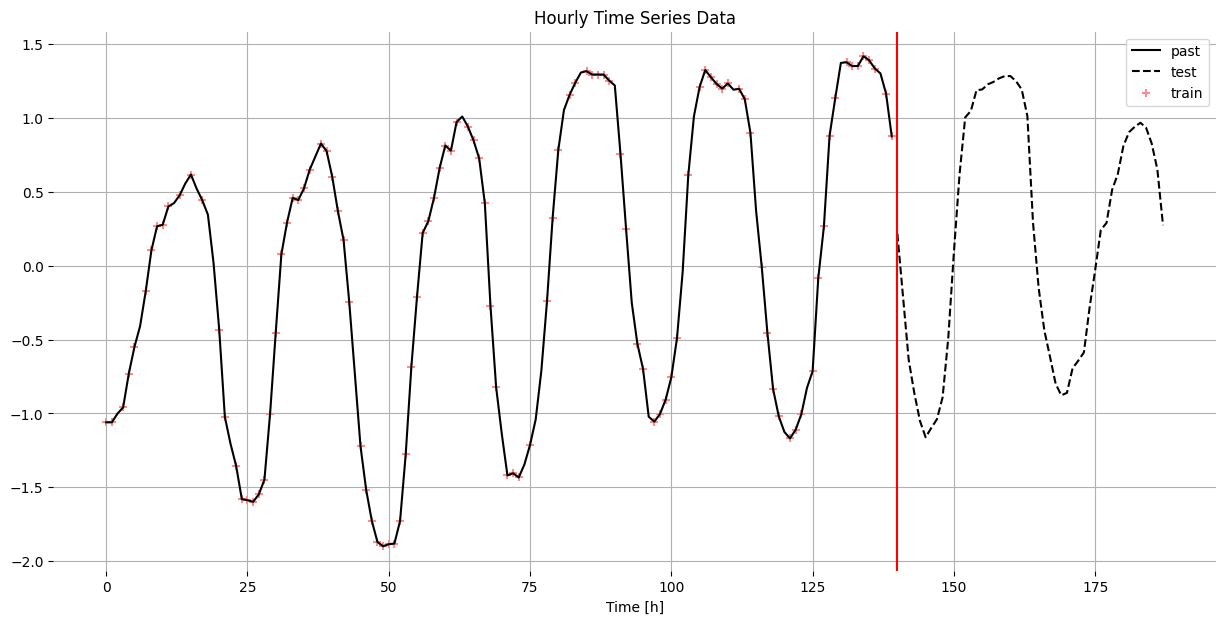

In [5]:
_, ax = plt.subplots(figsize=(15,7))

idx = 0

x_past = x_past_arr[idx,:]
y_past = y_past_arr[idx,:]
x_train = x_train_arr[idx,:]
y_train = y_train_arr[idx,:]
x_test = x_test_arr[idx,:]
y_test = y_test_arr[idx,:]

ax.plot(x_past, y_past, color='black', label='past')
ax.plot(x_test, y_test, color='black', linestyle='dashed', label='test')
ax.scatter(jnp.squeeze(x_train), jnp.squeeze(y_train),color="red", marker="+", alpha=0.45, label='train')
ax.axvline(x_test[0], color='red')

ax.set_title('Hourly Time Series Data')
ax.set_xlabel('Time [h]')
ax.legend()
ax.grid()
ax.set_frame_on(False)

In the following  different algorithms for time series forcasting are tried on the M4 data.

# Gaussian Process (GP)

For GP Regression we import the necessary modules from `ramsey`

In [ ]:
from ramsey.train import train_gaussian_process
from ramsey.covariance_functions import ExponentiatedQuadratic, Periodic, Linear
from ramsey.models import GP

Next we define the kernel. As shown below a kombination of different basic kernels is used.

In [7]:
def _gaussian_process(**kwargs):
    kernel = Periodic(24)  + ExponentiatedQuadratic() + Linear()
    gp = GP(kernel)
    return gp(**kwargs)

Next we define functions for training the GP and plotting the results.

In [8]:
def train_gp(key, x, y):
    init_key, train_key = random.split(key, 2)
    gaussian_process = hk.transform(_gaussian_process)
    params = gaussian_process.init(init_key, x=x)

    params, _ = train_gaussian_process(
      gaussian_process,
      params,
      train_key,
      x=x,
      y=y,
    )

    return gaussian_process, params

def plot(ax, key, gaussian_process, params, x_past, y_past, x_train, y_train, x_test, y_test):

    x_star = jnp.concatenate((x_past, x_test))
    
    ax.plot(
        jnp.squeeze(x_past), jnp.squeeze(y_past), 
        color="black", alpha=1, label='past data')

    ax.plot(
        jnp.squeeze(x_test), jnp.squeeze(y_test), 
        color="black", alpha=1, linestyle='dashed', label='test data')

    ax.axvline(x_test[0], color='red')

    ax.scatter(
        jnp.squeeze(x_train), jnp.squeeze(y_train),
        color="red", marker="+", alpha=0.45, label='train data')

    posterior_dist = gaussian_process.apply(
        params=params,
        rng=key,
        x=x_train,
        y=y_train,
        x_star=x_star,
    )

    y_star = posterior_dist.mean()
    ax.plot(
        jnp.squeeze(x_star), jnp.squeeze(y_star), 
        color="blue", alpha=0.45,label='Posterior mean')

    sigma = posterior_dist.stddev()
    ucb = y_star +  1.644854  * sigma
    lcb = y_star -  1.644854  * sigma
    ax.fill_between(
        jnp.squeeze(x_star), lcb, ucb, 
        color="grey", alpha=0.2, label='90% Posterior interval')

    ax.legend(ncol=3, loc='lower center',frameon=True)
    ax.grid()
    ax.set_frame_on(False)

Finally one GP for every loaded times series is trained and predictions are made.

-----------------------------------------------------------
Train GP for Time Series 1/4
MLL at 0: -49.60
MLL at 100: -32.44
MLL at 200: -1.75
MLL at 300: 37.19
MLL at 400: 57.14
MLL at 500: 66.33
MLL at 600: 70.48
MLL at 700: 71.78
MLL at 800: 72.21
MLL at 900: 72.43
MLL at 999: 72.56
-----------------------------------------------------------
Train GP for Time Series 2/4
MLL at 0: -122.26
MLL at 100: -105.95
MLL at 200: -96.60
MLL at 300: -92.23
MLL at 400: -90.10
MLL at 500: -89.06
MLL at 600: -88.56
MLL at 700: -88.22
MLL at 800: -87.92
MLL at 900: -87.62
MLL at 999: -87.33
-----------------------------------------------------------
Train GP for Time Series 3/4
MLL at 0: -77.03
MLL at 100: -42.11
MLL at 200: -9.35
MLL at 300: 21.87
MLL at 400: 51.33
MLL at 500: 78.78
MLL at 600: 103.94
MLL at 700: 126.88
MLL at 800: 148.65
MLL at 900: 167.75
MLL at 999: 182.17
-----------------------------------------------------------
Train GP for Time Series 4/4
MLL at 0: -86.98
MLL at 100: -54.2

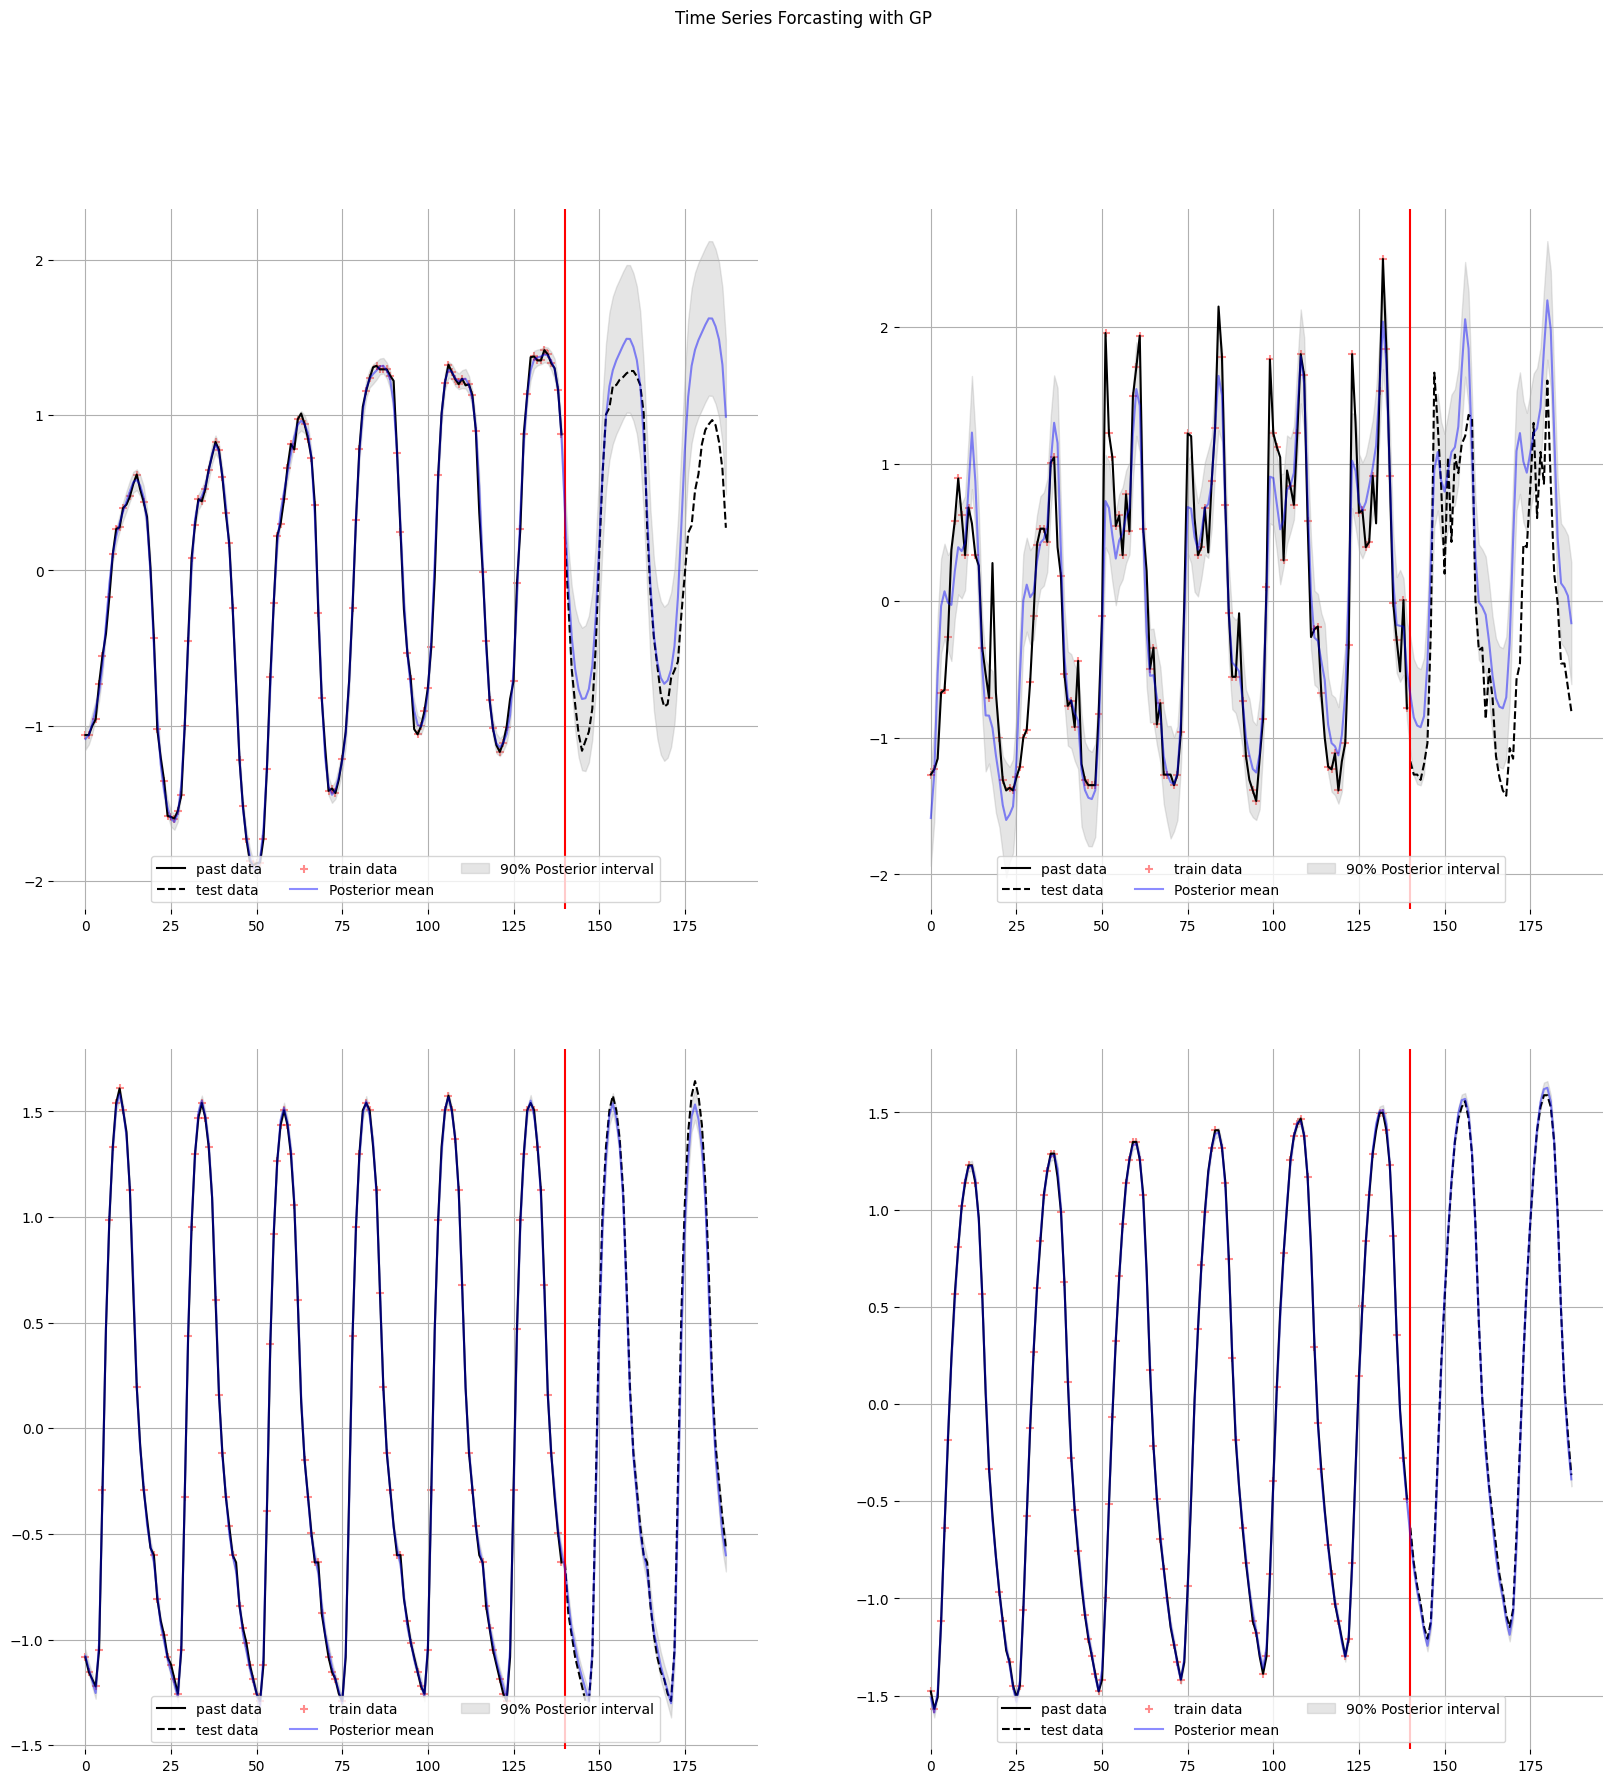

In [9]:
fig, axes = plt.subplots(figsize=(20, 20), nrows=2, ncols=2)
fig.suptitle('Time Series Forcasting with GP')

for _, (idx, ax) in enumerate(zip(range(n_series), axes.flatten())):

    print('-----------------------------------------------------------')
    print('Train GP for Time Series %d/%d' % (idx+1, n_series))
    x_past = x_past_arr[idx, jnp.newaxis].T
    y_past = y_past_arr[idx, jnp.newaxis].T
    x_train = x_train_arr[idx, jnp.newaxis].T
    y_train = y_train_arr[idx, jnp.newaxis].T
    x_test = x_test_arr[idx, jnp.newaxis].T
    y_test = y_test_arr[idx, jnp.newaxis].T

    gaussian_process, params = train_gp(next(rng_seq),  x_train, y_train)

    plot(
        ax, next(rng_seq), gaussian_process, params,
        x_past, y_past, x_train, y_train, x_test, y_test
    )


# Neural Process (NP)

For NP Regression we import the necessary modules from `ramsey`

In [10]:
from ramsey.train import train_neural_process
from ramsey.contrib.models import RANP
from ramsey.attention import MultiHeadAttention

Next we define a recurrent attentive neural process.

In [11]:
def _neural_process(**kwargs):
    dim = 128
    np = RANP(
        decoder=hk.DeepRNN(
            [
                hk.LSTM(hidden_size=40),
                jax.nn.relu,
                hk.LSTM(hidden_size=40),
                jax.nn.relu,
                hk.Linear(2),
            ]
        ),
        latent_encoder=(hk.nets.MLP([dim] * 3), hk.nets.MLP([dim, dim * 2])),
        deterministic_encoder=(
            hk.nets.MLP([dim] * 3),
            MultiHeadAttention(
                num_heads=8, head_size=16, embedding=hk.nets.MLP([dim] * 2)
            ),
        ),
    )
    return np(**kwargs)

Next we define functions for training the NP and plotting the results.

In [12]:
def train_np(key, x, y, n_context, n_target):

    init_key, train_key = random.split(key, 2)
    neural_process = hk.transform(_neural_process)
    params = neural_process.init(
        init_key, x_context=x, y_context=y, x_target=x
    )

    params, _ = train_neural_process(
        neural_process,
        params,
        train_key,
        x=x,
        y=y,
        n_context=n_context,
        n_target=n_target,
        n_iter=5000
    )

    return neural_process, params


def plot(   key, neural_process, params, 
            x_past_arr, y_past_arr, x_train_arr, y_train_arr, x_test_arr, y_test_arr,
            n_context, n_target):

    key, sample_key = random.split(key, 2)

    sample_idxs = random.choice(
    sample_key,
    x_past_arr.shape[1] + x_test_arr.shape[1],
    shape=(n_context + n_target,),
    replace=False,
    )

    n_series = jnp.shape(x_train_arr)[0]

    fig, axes = plt.subplots(figsize=(20, 20), nrows=2, ncols=2)
    fig.suptitle('Time Series Forcasting with NP')

    for _, (idx, ax) in enumerate(zip(range(n_series), axes.flatten())):

        x_past = x_past_arr[idx, jnp.newaxis].T
        y_past = y_past_arr[idx, jnp.newaxis].T
        x_train = x_train_arr[idx, jnp.newaxis].T
        y_train = y_train_arr[idx, jnp.newaxis].T
        x_test = x_test_arr[idx, jnp.newaxis].T
        y_test = y_test_arr[idx, jnp.newaxis].T

        x_star = jnp.concatenate((x_past, x_test))
        
        ax.plot(
            jnp.squeeze(x_past), jnp.squeeze(y_past), 
            color="black", alpha=1, label='past data')

        ax.plot(
            jnp.squeeze(x_test), jnp.squeeze(y_test), 
            color="black", alpha=1, linestyle='dashed', label='test data')

        ax.axvline(x_test[0], color='red')

        ax.scatter(
            jnp.squeeze(x_train), jnp.squeeze(y_train),
            color="red", marker="+", alpha=0.45, label='training data')

        x_context = x_train[jnp.newaxis, sample_idxs , :]
        y_context = y_train[jnp.newaxis, sample_idxs , :]
        x_star = x_star[jnp.newaxis, :, :]

        y_star  = neural_process.apply(
            params=params,
            rng=key,
            x_context=x_context,
            y_context=y_context,
            x_target=x_star
        ).mean


        ax.plot(
            jnp.squeeze(x_star), jnp.squeeze(y_star), 
            color="blue", alpha=0.45,label='Posterior mean')

        ax.legend(ncol=3, loc='lower center',frameon=True)
        ax.grid()
        ax.set_frame_on(False)

Finally the NP with 4 times series is trained and predictions are made.

ELBO at 0: -201.4049278467469
ELBO at 1000: -157.70474417577094
ELBO at 2000: -155.0908791125491
ELBO at 3000: -193.15725867534454
ELBO at 4000: -154.77819441518028
ELBO at 4999: -156.02423377397332


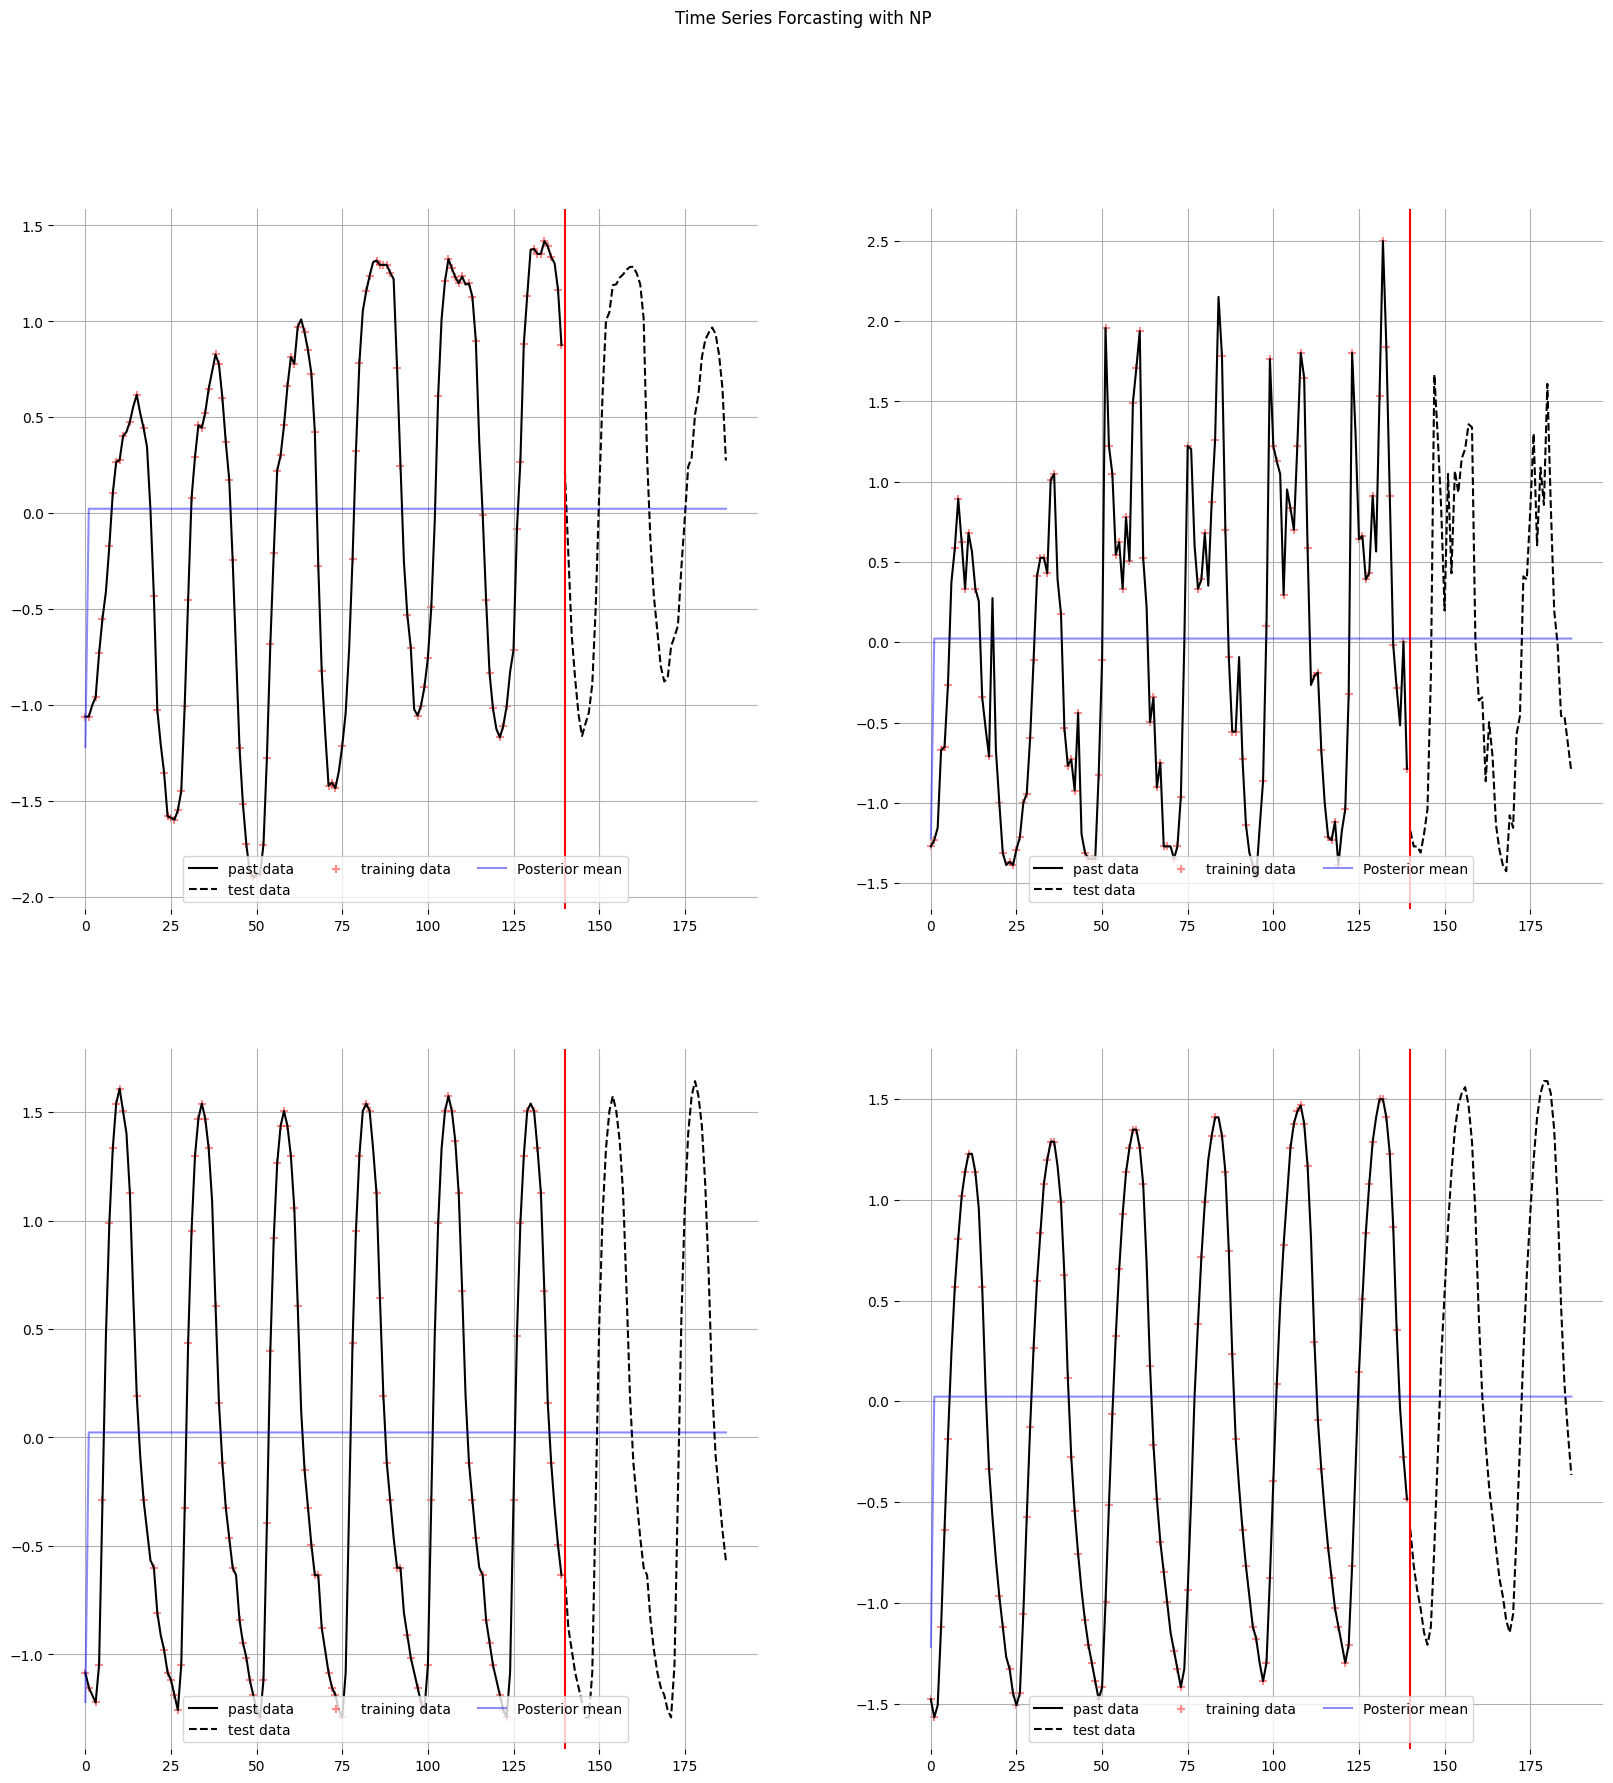

In [13]:
# the NP implementation requires that n_context + n_target <= n_train
n_context = int((n_train-1)*0.3) 
n_target = int((n_train-1)*0.7)

neural_process, params = train_np(next(rng_seq), x_train_arr[:,:,jnp.newaxis], y_train_arr[:,:,jnp.newaxis], n_context, n_target)

plot(
    next(rng_seq), neural_process, params,
    x_past_arr, y_past_arr, 
    x_train_arr, y_train_arr,
    x_test_arr, y_test_arr,
    n_context, n_target
)